Analysing the Labor Herald Donors
===

This Notebook collects and analyses information about the donors to the Labor Herald and other Pozible crowdfunding journalism campaigns.

Labor Herald Donors
----

First, let's grab a list of donors to the Labor Herald.

Digging around the Pozible site, it looks like these links give a list of supporters for each project:

http://www.pozible.com/project/pnav/PROJECTID/supporters

Supporters come back at 20 per page, including their name, profile pic, the number of other projects they have funded, their location, and a link to their profile.

Let's grab them with a script that stops at the last page, indicated by a bold font for the last item in the page navigation at the bottom of the page

In [33]:
import requests
from bs4 import BeautifulSoup

# This function takes a project number and returns a list of supporters 
# the number of supporters and the number of supporters who haven't supported other projects
def supgetter(x):
    link = "http://www.pozible.com/project/pnav/%s/supporters/"%str(x)

    supporters = []
    zero = 0
    counter = 0
    while True:
        sups = requests.get(link+str(counter)) 
        soup = BeautifulSoup(sups.content)
        peeps = soup.find_all("div",class_="pnav_support_con")

        for peep in peeps:
            supporter = {}
            try:
                supporter['Profile'] = peep.find("a",class_="pnav_suptx").get("href")
            except:
                pass
            try:
                supporter['Image'] = peep.find("a",class_="pnav_suptx").find("img").get("src")
            except:
                pass
            try:
                supporter['Name'] = peep.find("a",class_="pnav_suprname").text
            except:
                pass
            try:
                supporter['Location'] = peep.find("a",class_="pnav_suprname").nextSibling.nextSibling.text
            except:
                pass
            try:
                supporter['Other projects'] = int(peep.find("div",class_="other_people").contents[0].strip()[1:])
            except:
                zero += 1
                pass
            supporters.append(supporter)    
        counter += 20
        # This next part stops on the final page
        if "data-url" not in soup.find("div",class_="page").findChildren()[-1].attrs.keys():
            break
    return (supporters,len(supporters),zero)

Running this code at midday on Friday, 24 July 2015, gave me 654 supporters. At that time, $39,674 had been pledged. What can we learn about these supporters?

In [34]:
import pandas as pd

lh = supgetter(195895)
df = pd.DataFrame(lh[0])

First, what proportion of supporters have funded other projects on Pozible?

In [35]:
def pp(name,sup):
    print "First-time supporters of the %s campaign represent %s of %s or %s per cent."%(name,sup[2],sup[1],sup[2]/float(sup[1])*100)

How does that compare to other top Australian journalism campaigns? The four to attract the most funding are the New Matilda Relaunch (raised \$175,838, code is 105), Protect The Star Observer (\$103,938, 185044), Lost Perth - The Book (\$71,280, 27845) and Dan Ilic's A Rational Fear (\$52,825, 178557). What about a comparison of first-time pledgers?

In [36]:
nm = supgetter(105)
so = supgetter(185044)
lp = supgetter(27845)
rf = supgetter(178557)

In [121]:
pp("Labor Herald",lh)
pp("New Matilda Relaunch",nm)
pp("Protect The Star Observer",so)
pp("Lost Perth - The Book",lp)
pp("A Rational Fear",rf)


First-time supporters of the Labor Herald campaign represent 571 of 654 or 87.3088685015 per cent.
First-time supporters of the New Matilda Relaunch campaign represent 743 of 1146 or 64.8342059337 per cent.
First-time supporters of the Protect The Star Observer campaign represent 298 of 509 or 58.5461689587 per cent.
First-time supporters of the Lost Perth - The Book campaign represent 1062 of 1204 or 88.2059800664 per cent.
First-time supporters of the A Rational Fear campaign represent 298 of 716 or 41.6201117318 per cent.


In [146]:
# Let's put this in a table

pd.DataFrame([["Labor Herald",lh[1],lh[2],round(lh[2]/float(lh[1]),2)],
                    ["New Matilda Relaunch",nm[1],nm[2],round(nm[2]/float(nm[1]),2)],
                    ["Protect The Star Observer",so[1],so[2],round(so[2]/float(so[1]),2)],
                    ["Lost Perth - The Book",lp[1],lp[2],round(lp[2]/float(lp[1]),2)],
                    ["A Rational Fear",rf[1],rf[2],round(rf[2]/float(rf[1]),2)]],
             columns=['Campaign','Total supporters','Sole supporters','Sole proportion']).sort("Sole proportion").to_html(index=False).replace("\n","")

u'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Campaign</th>      <th>Total supporters</th>      <th>Sole supporters</th>      <th>Sole proportion</th>    </tr>  </thead>  <tbody>    <tr>      <td> A Rational Fear</td>      <td> 716</td>      <td> 298</td>      <td> 0.42</td>    </tr>    <tr>      <td> Protect The Star Observer</td>      <td> 509</td>      <td> 298</td>      <td> 0.59</td>    </tr>    <tr>      <td> New Matilda Relaunch</td>      <td> 1146</td>      <td> 743</td>      <td> 0.65</td>    </tr>    <tr>      <td> Labor Herald</td>      <td> 654</td>      <td> 571</td>      <td> 0.87</td>    </tr>    <tr>      <td> Lost Perth - The Book</td>      <td> 1204</td>      <td> 1062</td>      <td> 0.88</td>    </tr>  </tbody></table>'

Has any supporter backed multiple projects?

In [134]:
df = pd.DataFrame()
for d in [('Labor Herald',lh),('New Matilda',nm),('Star Observer',so),('Lost Perth',lp),('Rational Fear',rf)]:
    da = pd.DataFrame(d[1][0])
    da['Campaign'] = d[0]
    df = pd.concat([df,da],axis=0)
df.groupby('Profile').count()['Campaign'].order(ascending=False)[:5]

Profile
http://www.pozible.com/profile/621      3
http://www.pozible.com/profile/1605     3
http://www.pozible.com/profile/111      2
http://www.pozible.com/profile/93649    2
http://www.pozible.com/profile/93096    2
Name: Campaign, dtype: int64

Indeed they have - Pozible co-founder Rick Chen has backed three and so has journalist Benjamin Law.

Have many backed the Labor Herald as well as others?

In [124]:
multibackers = df.groupby('Profile').count()['Image'][df.groupby('Profile').count()['Image']>1].index.unique()
lhmultibackers = df[(df['Profile'].isin(multibackers))&(df['Campaign']=='Labor Herald')].groupby(['Profile','Campaign']).count().reset_index()['Profile'].unique()
lhmultibackers

array(['http://www.pozible.com/profile/125242',
       'http://www.pozible.com/profile/1692',
       'http://www.pozible.com/profile/1755',
       'http://www.pozible.com/profile/1832',
       'http://www.pozible.com/profile/1950',
       'http://www.pozible.com/profile/2469',
       'http://www.pozible.com/profile/31534',
       'http://www.pozible.com/profile/3318'], dtype=object)

In [125]:
df[df['Profile'].isin(lhmultibackers)].groupby(['Profile','Campaign']).count()['Image']

Profile                                Campaign     
http://www.pozible.com/profile/125242  Labor Herald     1
                                       Star Observer    1
http://www.pozible.com/profile/1692    Labor Herald     1
                                       New Matilda      1
http://www.pozible.com/profile/1755    Labor Herald     1
                                       New Matilda      1
http://www.pozible.com/profile/1832    Labor Herald     1
                                       New Matilda      1
http://www.pozible.com/profile/1950    Labor Herald     1
                                       New Matilda      1
http://www.pozible.com/profile/2469    Labor Herald     1
                                       New Matilda      1
http://www.pozible.com/profile/31534   Labor Herald     1
                                       Rational Fear    1
http://www.pozible.com/profile/3318    Labor Herald     1
                                       New Matilda      1
Name: Image, dtype:

Indeed there have been - 8 in total - most backing New Matilda as well.

What does the distribution of pledgers for each project look like? (Excluding some outliers like Rick Chen - he blows out the charts badly!)

Populating the interactive namespace from numpy and matplotlib


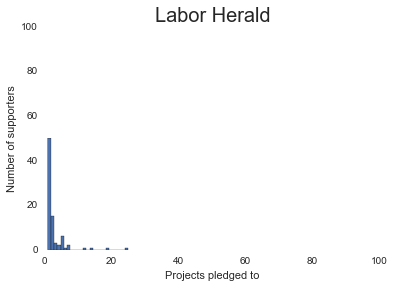

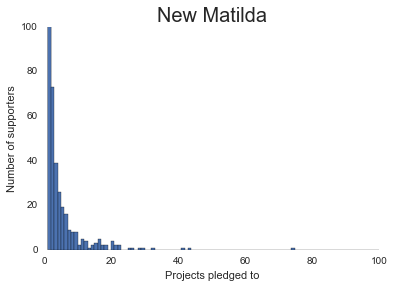

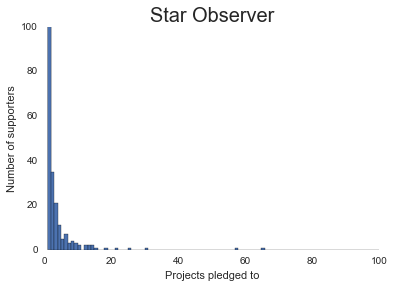

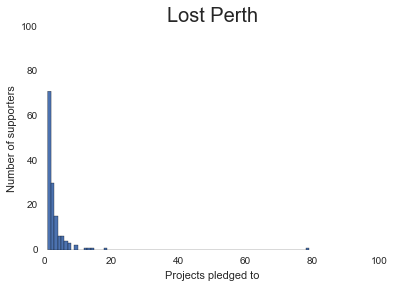

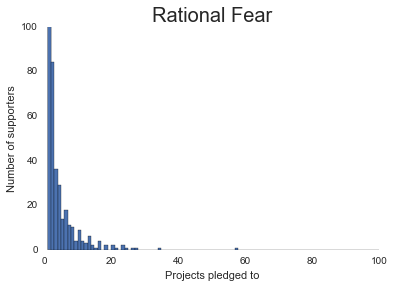

In [133]:
%pylab inline
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display

for q in [('Labor Herald',lh),('New Matilda',nm),('Star Observer',so),('Lost Perth',lp),('Rational Fear',rf)]:
    fig,ax=plt.subplots()
    dq = pd.DataFrame(q[1][0])
    plt.hist(dq['Other projects'],range=(1,dq['Other projects'].max()),bins=dq['Other projects'].max(),align='mid')
    ax.set_xlabel('Projects pledged to')
    ax.set_ylabel('Number of supporters')
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_title(q[0],fontsize=20)

Now let's create a table of all Labor Herald pledgers to print to the web.

In [135]:
df[df['Campaign']=='Labor Herald'].to_csv('lhsups.csv',encoding='utf-8') # Backup!

In [147]:
import pandas as pd
df = pd.read_csv('lhsups.csv')
df['Photo'] = df['Image'].apply(lambda x: '<img src="'+str(x)+'" width=50px height=50px></img>')
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option('display.max_colwidth', -1)
df = df[df['Name']!='Anonymous']
df[['Name','Location','Photo']].to_html(index=False,escape=False).replace("\n","")

u'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Name</th>      <th>Location</th>      <th>Photo</th>    </tr>  </thead>  <tbody>    <tr>      <td> chen52</td>      <td> Shanghai, CN</td>      <td> <img src="//d3nm4kec9k9dav.cloudfront.net/cache/aicon/00/00/03/52/352845/352845_50_50.png?vvv=20141218v2?v=1435198401" width=50px height=50px></img></td>    </tr>    <tr>      <td> Anneliese Clare</td>      <td> Dollar, Alabama</td>      <td> <img src="http://graph.facebook.com/521903948/picture?pzv=1437660000&width=200&height=200" width=50px height=50px></img></td>    </tr>    <tr>      <td> Tim Yarham</td>      <td> Brisbane, Australia</td>      <td> <img src="//d3nm4kec9k9dav.cloudfront.net/cache/aicon/00/00/00/36/36113/36113_50_50.png?vvv=20141218v2?v=1418967993" width=50px height=50px></img></td>    </tr>    <tr>      <td> Bryce Roney</td>      <td> Canberra, Australian Capital Territory</td>      <td> <img src="http://graph.facebook.com/502554